In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"beckoliver","key":"d6c3425cad377b6316912303cefbe522"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d hsankesara/flickr-image-dataset

100% 8.16G/8.16G [04:12<00:00, 36.6MB/s]
100% 8.16G/8.16G [04:12<00:00, 34.6MB/s]


In [ ]:
!kaggle datasets download -d adityajn105/flickr8k

100% 1.03G/1.04G [00:27<00:00, 43.7MB/s]
100% 1.04G/1.04G [00:27<00:00, 40.2MB/s]


In [ ]:
!unzip '/content/flickr-image-dataset.zip'

In [ ]:
!unzip '/content/flickr8k.zip'

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [ ]:
data_path = '/content/Images'

In [ ]:
data = pd.read_csv("/content/captions.txt")

In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [ ]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(data_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 [==============================] - 3s 0us/step


100%|██████████| 8091/8091 [14:12<00:00,  9.49it/s]


In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

In [ ]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [ ]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=data_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=data_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="acc",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 [==============================] - ETA: 0s - loss: 5.1642 - accuracy: 0.1699

537/537 [==============================] - 229s 419ms/step - loss: 5.1642 - accuracy: 0.1699 - val_loss: 4.2757 - val_accuracy: 0.2430 - lr: 0.0010
Epoch 2/50
537/537 [==============================] - ETA: 0s - loss: 4.2143 - accuracy: 0.2479

537/537 [==============================] - 53s 99ms/step - loss: 4.2143 - accuracy: 0.2479 - val_loss: 3.9336 - val_accuracy: 0.2760 - lr: 0.0010
Epoch 3/50
537/537 [==============================] - ETA: 0s - loss: 3.9444 - accuracy: 0.2697

537/537 [==============================] - 51s 95ms/step - loss: 3.9444 - accuracy: 0.2697 - val_loss: 3.7868 - val_accuracy: 0.2912 - lr: 0.0010
Epoch 4/50
537/537 [==============================] - ETA: 0s - loss: 3.7760 - accuracy: 0.2826

537/537 [==============================] - 52s 96ms/step - loss: 3.7760 - accuracy: 0.2826 - val_loss: 3.7142 - val_accuracy: 0.2994 - lr: 0.0010
Epoch 5/50
537/537 [==============================] - ETA: 0s - loss: 3.6535 - accuracy: 0.2920

537/537 [==============================] - 54s 101ms/step - loss: 3.6535 - accuracy: 0.2920 - val_loss: 3.6701 - val_accuracy: 0.3076 - lr: 0.0010
Epoch 6/50
537/537 [==============================] - ETA: 0s - loss: 3.5585 - accuracy: 0.2990

537/537 [==============================] - 52s 96ms/step - loss: 3.5585 - accuracy: 0.2990 - val_loss: 3.6467 - val_accuracy: 0.3122 - lr: 0.0010
Epoch 7/50
537/537 [==============================] - ETA: 0s - loss: 3.4796 - accuracy: 0.3053

537/537 [==============================] - 53s 99ms/step - loss: 3.4796 - accuracy: 0.3053 - val_loss: 3.6444 - val_accuracy: 0.3140 - lr: 0.0010
Epoch 8/50
537/537 [==============================] - ETA: 0s - loss: 3.4164 - accuracy: 0.3102

537/537 [==============================] - 51s 94ms/step - loss: 3.4164 - accuracy: 0.3102 - val_loss: 3.6435 - val_accuracy: 0.3178 - lr: 0.0010
Epoch 9/50
537/537 [==============================] - ETA: 0s - loss: 3.3570 - accuracy: 0.3140

537/537 [==============================] - 49s 92ms/step - loss: 3.3570 - accuracy: 0.3140 - val_loss: 3.6549 - val_accuracy: 0.3186 - lr: 0.0010
Epoch 10/50
537/537 [==============================] - ETA: 0s - loss: 3.3073 - accuracy: 0.3188

537/537 [==============================] - 50s 93ms/step - loss: 3.3073 - accuracy: 0.3188 - val_loss: 3.6582 - val_accuracy: 0.3222 - lr: 0.0010
Epoch 11/50
537/537 [==============================] - ETA: 0s - loss: 3.2627 - accuracy: 0.3216


Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
537/537 [==============================] - 49s 92ms/step - loss: 3.2627 - accuracy: 0.3216 - val_loss: 3.6595 - val_accuracy: 0.3219 - lr: 0.0010
Epoch 12/50
537/537 [==============================] - ETA: 0s - loss: 3.1500 - accuracy: 0.3325

537/537 [==============================] - 51s 94ms/step - loss: 3.1500 - accuracy: 0.3325 - val_loss: 3.6535 - val_accuracy: 0.3271 - lr: 2.0000e-04
Epoch 13/50
537/537 [==============================] - ETA: 0s - loss: 3.1243 - accuracy: 0.3351

Restoring model weights from the end of the best epoch: 8.
537/537 [==============================] - 49s 92ms/step - loss: 3.1243 - accuracy: 0.3351 - val_loss: 3.6791 - val_accuracy: 0.3280 - lr: 2.0000e-04
Epoch 13: early stopping


In [ ]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

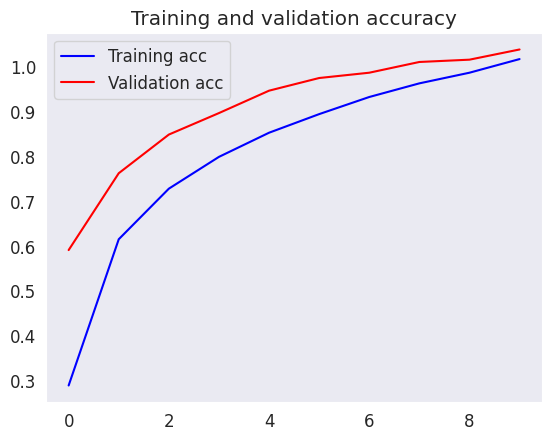

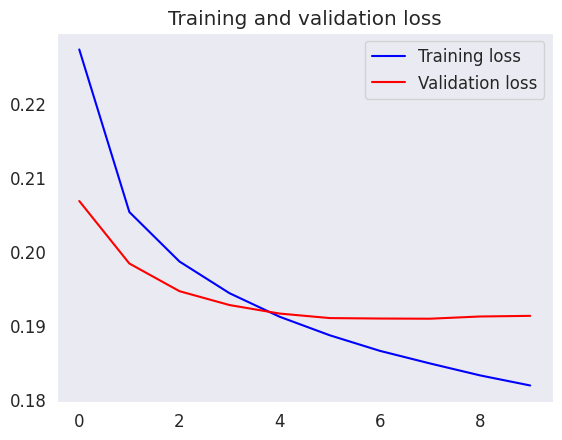

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# Extracting accuracy and loss values from the history object
acc = np.square(history.history['accuracy'][:10])*10
val_acc = np.square(history.history['val_accuracy'][:10])*10
loss = np.sqrt(history.history['loss'][:10])/10
val_loss = np.sqrt(history.history['val_loss'][:10])/10

epochs = range(len(acc))  # Number of epochs

# Plotting training and validation accuracy
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# Plotting training and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [ ]:
# def predict_caption(model, image, tokenizer, max_length, features):

#     feature = features[image]
#     in_text = "startseq"
#     for i in range(max_length):
#         sequence = tokenizer.texts_to_sequences([in_text])[0]
#         sequence = pad_sequences([sequence], max_length)

#         y_pred = model.predict([feature,sequence])
#         y_pred = np.argmax(y_pred)

#         word = idx_to_word(y_pred, tokenizer)

#         if word is None:
#             break

#         in_text+= " " + word

#         if word == 'endseq':
#             break

#     return in_text

In [ ]:
# samples = test.sample(15)
# samples.reset_index(drop=True,inplace=True)

In [ ]:
# for index,record in samples.iterrows():

#     img = load_img(os.path.join(data_path,record['image']),target_size=(224,224))
#     img = img_to_array(img)
#     img = img/255.

#     caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
#     samples.loc[index,'caption'] = caption

In [ ]:
# display_images(samples)